## **Importing Libraries**

In [1]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav
import pandas as pd
import os
import numpy as np
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
import catboost as cb

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

## <u>Displaying all the genres in the current dataset:-</u>

In [2]:
path = './archive/Data'
print(list(os.listdir(f'{path}/genres_original/')))

['metal', 'hiphop', 'classical', 'disco', 'jazz', 'country', 'reggae', 'pop', 'rock', 'blues']


# **Exploring some Basic Functionalities with Audio Data**

### <u>Defining a function plot_sound(), which plays the audio file and displays plot of amplitude envelope of waveform.</u>

In [3]:
def plot_sound(path):
    plt.figure(figsize=(14, 5))
    x, sr = librosa.load(path)
    print("length {}, sample-rate {}".format(x.shape, sr))
    librosa.display.waveplot(x, sr=sr)
    
    return x

### <u>Taking one audio from  blues, rock and pop songs:-</u>

length (661794,), sample-rate 22050


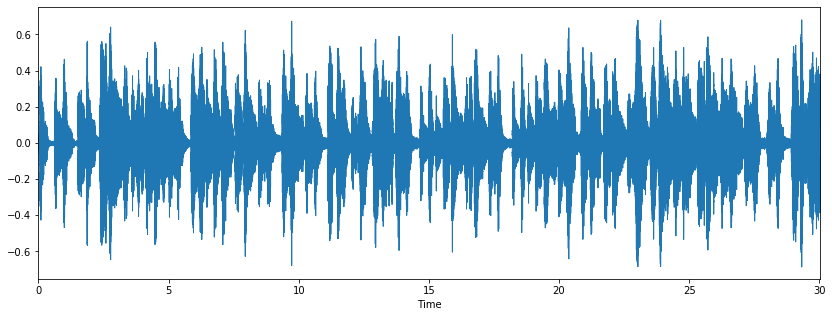

In [4]:
blues_path = './archive/Data/genres_original/blues/blues.00001.wav'
blues_audio = plot_sound(blues_path)
ipd.Audio(blues_path)

length (661794,), sample-rate 22050


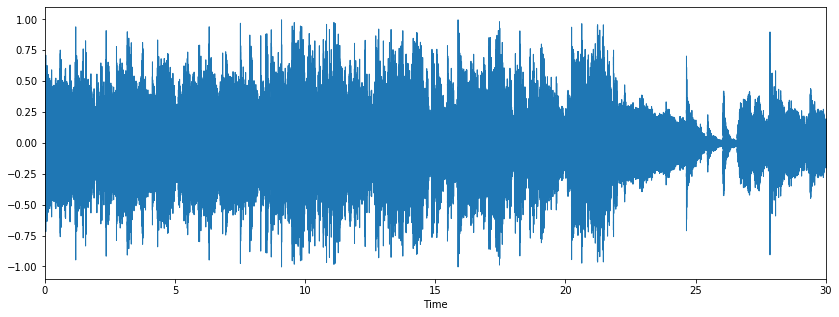

In [5]:
rock_path = './archive/Data/genres_original/rock/rock.00001.wav'
rock_audio = plot_sound(rock_path)
ipd.Audio(rock_path)

length (661504,), sample-rate 22050


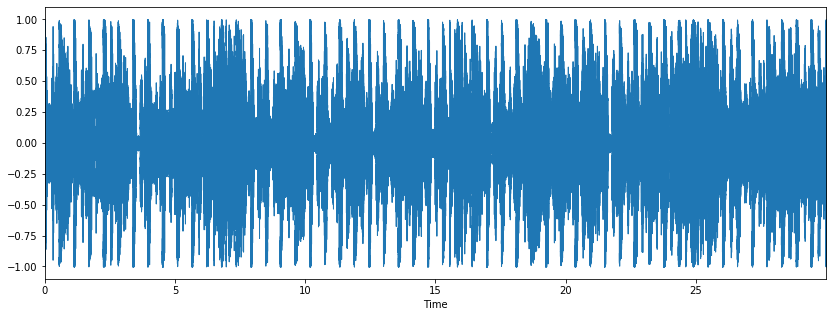

In [6]:
pop_path = './archive/Data/genres_original/pop/pop.00001.wav'
pop_audio = plot_sound(pop_path)
ipd.Audio(pop_path)

# <u>Plotting a Spectogram</u>
### (The vertical axis represents frequencies (from 0 to 10kHz), and the horizontal axis represents the time of the clip.)

In [7]:
def disp_spectogram(x, sr):
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    
    # Since all action is taking place at the bottom of the spectrum, we can convert the frequency axis to a logarithmic one.
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

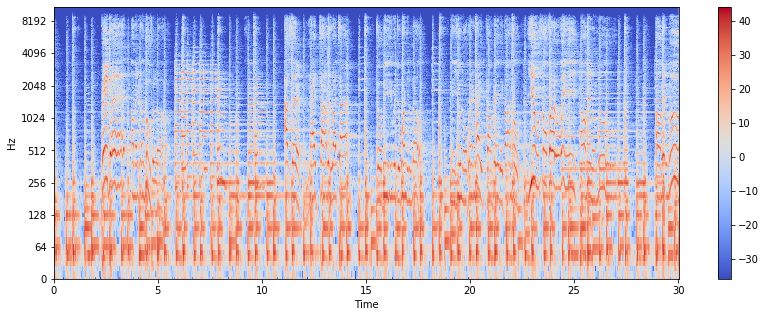

In [8]:
x, sr = librosa.load(blues_path)
disp_spectogram(x,sr)

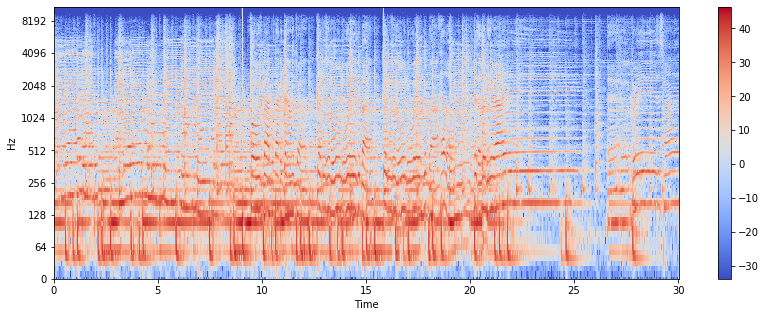

In [9]:
x, sr = librosa.load(rock_path)
disp_spectogram(x,sr)

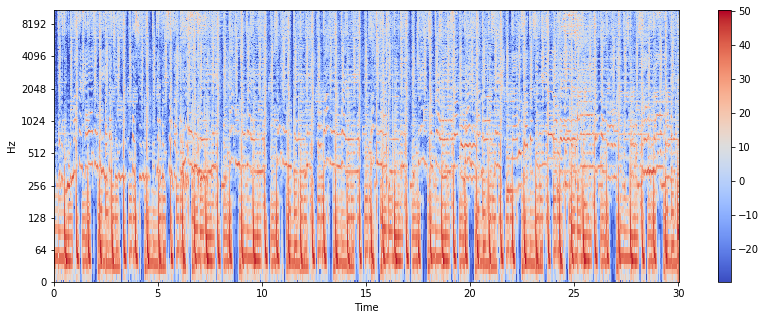

In [10]:
x, sr = librosa.load(pop_path)
disp_spectogram(x,sr)

## Thus, we can see how the spectogram varies for 3 different music genres of blues, rock and pop. 

# **Loading the Dataset**

In [11]:
df = pd.read_csv('./archive/Data/features_3_sec.csv')

In [12]:
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [13]:
df.shape

(9990, 60)

## <u>Displaying information about the dataset:-</u>

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

### <u>Checking whether the dataset is balanced or not:</u>

In [15]:
df['label'].value_counts()

blues        1000
metal        1000
jazz         1000
pop          1000
reggae       1000
disco         999
hiphop        998
rock          998
classical     998
country       997
Name: label, dtype: int64

## <u>Conclusion from the above calculations</u>
### - The GTZAN Dataset is balanced. 
### - We can now proceed with the graphical representation of our data

# **Representing Dataset Features using Relevant Graphs**

## <u>Correlation Heatmap for Feature Means</u>

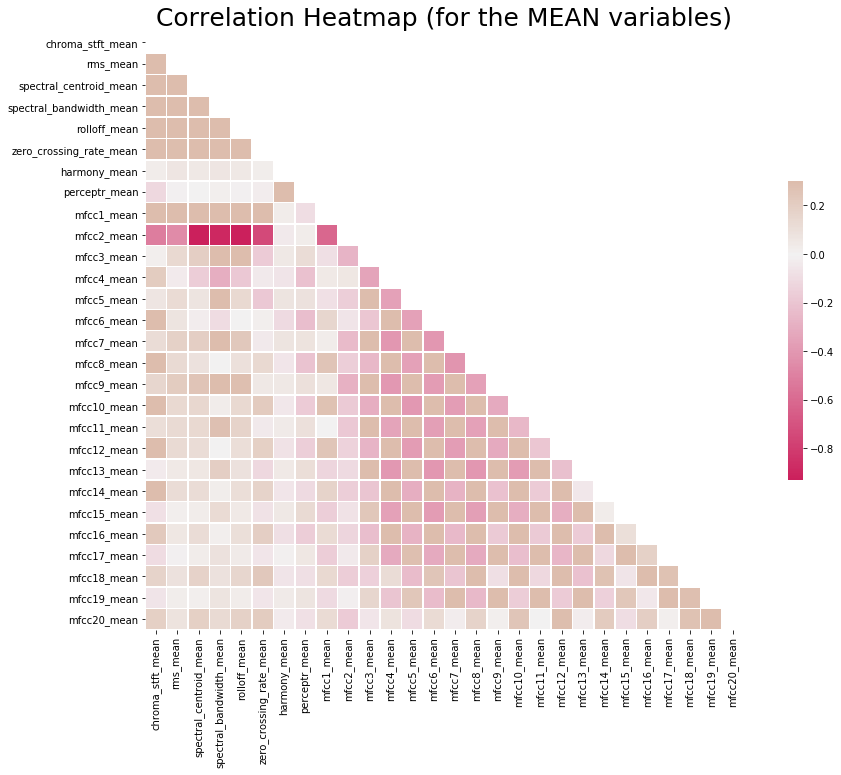

In [16]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Correlation Heatmap.jpg")

## <u>Box Plot for Genre Distributions</u>

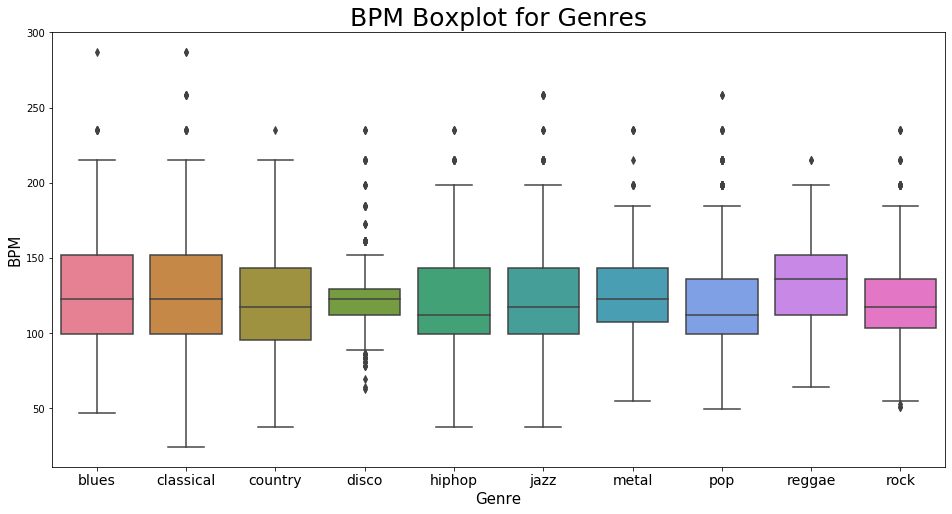

In [17]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")

# <u>Principal Component Analysis- To visualize possible groups of genres</u>

## <u>Steps Involved:</u>
### &emsp;- Normalization
### &emsp;- PCA
### &emsp;- The Scatter Plot

In [18]:
from sklearn import preprocessing

data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# Normalizing X 
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#PCA 2 Components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

# 44.93 variance explained

array([0.26745621, 0.18238003])

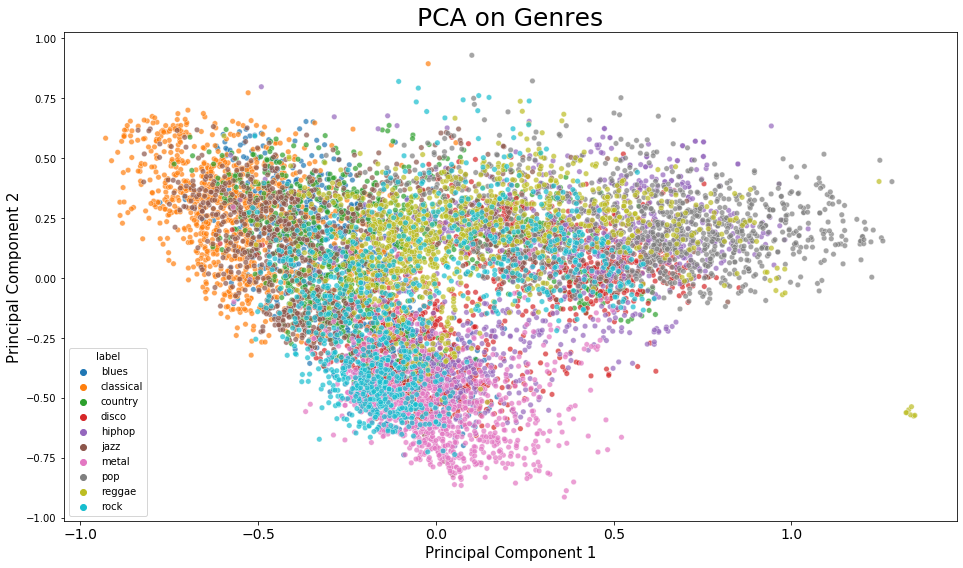

In [19]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 30);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scatterplot.jpg")

# **Data Preprocessing**

### <u>Converting the label values into integers</u>

In [20]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

### <u>Independent and dependent variables</u>

In [21]:
X = df.drop(['label','filename'],axis=1)
y = df['label'] 

In [22]:
print(x)

      label       tempo
0     blues  129.199219
1     blues  123.046875
2     blues  123.046875
3     blues  123.046875
4     blues  123.046875
...     ...         ...
9985   rock  123.046875
9986   rock   83.354335
9987   rock  123.046875
9988   rock  123.046875
9989   rock  234.907670

[9990 rows x 2 columns]


In [23]:
print(y)

0       0
1       0
2       0
3       0
4       0
       ..
9985    9
9986    9
9987    9
9988    9
9989    9
Name: label, Length: 9990, dtype: int64


### <u>Normalizing Data</u>

In [24]:
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

# **Train-Test Split**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6993, 58), (2997, 58), (6993,), (2997,))

# **Building the ML Models**

In [26]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy of the', title,' Model:', round(accuracy_score(y_test, preds), 5), '\n')

## <u>Choosing the best models out of the below models:-</u>

In [27]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter = 5000, random_state = 1)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decision trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decision tree")

# Random Forest
rforest = RandomForestClassifier(n_estimators =1000, max_depth = 10, random_state = 0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Catboost
cbc = cb.CatBoostClassifier(verbose = 0, eval_metric = 'Accuracy', loss_function = 'MultiClass')
model_assess(cbc,"Cat Boost Classifier")

Accuracy of the Naive Bayes  Model: 0.51518 

Accuracy of the Stochastic Gradient Descent  Model: 0.65599 

Accuracy of the KNN  Model: 0.80414 

Accuracy of the Decision tree  Model: 0.66333 

Accuracy of the Random Forest  Model: 0.80814 

Accuracy of the Support Vector Machine  Model: 0.74775 

Accuracy of the Cat Boost Classifier  Model: 0.90524 



## <u>Conclusion from the above ML Models (**ACCURACY** being the Deciding Parameter):</u>
### - The highest accuracy is with the Cat Boost Model.
### - Using this model as the Classifier, we now print its Confusion Matrix:-

In [28]:
# Final model
cbc = cb.CatBoostClassifier(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(X_train, y_train)
preds = cbc.predict(X_test)
print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

Accuracy : 0.90524 



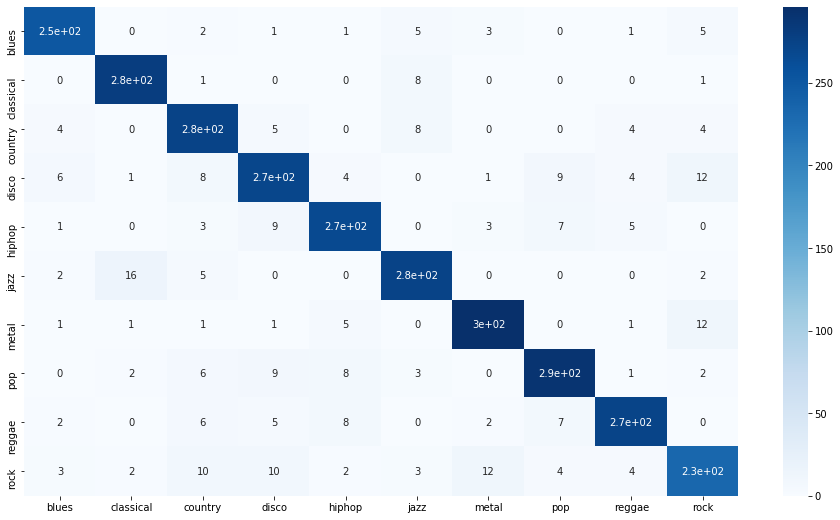

In [29]:
# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds)
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

# **Deep Learning Model**

## <u>Building the DL Model:</u>

In [30]:
X_train.shape[1]

58

In [31]:
model = Sequential()

model.add(Flatten(input_shape=(58,)))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 58)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               30208     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

## <u>Using Callbacks to prevent Model Overfitting</u>

In [32]:
early_stopping= EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5) 
check_pointer = ModelCheckpoint(filepath = 'clf-resnet-checkpoint.hdf5',verbose=1,save_best_only=True) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss',mode='min',verbose=1,patience=5,min_delta = 0.0001,factor=0.2) 
callbacks = [check_pointer,early_stopping,reduce_lr]

In [33]:
# compile the model
adam = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

## <u>Training our model by running it for 100 Epochs</u>

In [34]:
hist = model.fit(X_train, y_train,
                 validation_data = (X_test,y_test),
                 epochs = 100,
                 batch_size = 32, callbacks = [check_pointer,early_stopping])

Epoch 1/100
219/219 [==============================] - 2s 3ms/step - loss: 4.0260 - accuracy: 0.1396 - val_loss: 3.6194 - val_accuracy: 0.2996

Epoch 00001: val_loss improved from inf to 3.61943, saving model to clf-resnet-checkpoint.hdf5
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 3.3248 - accuracy: 0.2401 - val_loss: 2.9637 - val_accuracy: 0.3510

Epoch 00002: val_loss improved from 3.61943 to 2.96369, saving model to clf-resnet-checkpoint.hdf5
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 2.8182 - accuracy: 0.3099 - val_loss: 2.5427 - val_accuracy: 0.3787

Epoch 00003: val_loss improved from 2.96369 to 2.54275, saving model to clf-resnet-checkpoint.hdf5
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 2.4818 - accuracy: 0.3499 - val_loss: 2.2504 - val_accuracy: 0.4047

Epoch 00004: val_loss improved from 2.54275 to 2.25039, saving model to clf-resnet-checkpoint.hdf5
Epoch 5/100
219/219 [===========

In [35]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 1ms/step - loss: 1.1130 - accuracy: 0.6827
Test accuracy: 0.6826826930046082


# **Plotting Accuracy and Loss**

<Figure size 1440x1080 with 0 Axes>

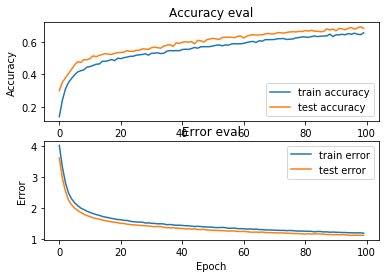

<Figure size 432x288 with 0 Axes>

In [36]:
plt.figure(figsize=(20,15))
fig, axs = plt.subplots(2)

# accuracy 
axs[0].plot(hist.history["accuracy"], label="train accuracy")
axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")
    
# Error 
axs[1].plot(hist.history["loss"], label="train error")
axs[1].plot(hist.history["val_loss"], label="test error")    
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")
    
plt.show()
plt.savefig('Accuracy Eval in Epochs.jpg')